In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
%matplotlib inline

/Users/ryanbarouki/miniconda3/envs/pytorchenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [4]:
def build_dataset(words, block_size=3):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = jnp.array(X)
    Y = jnp.array(Y)
    print(X.shape, X.dtype, Y.shape, Y.dtype)
    return X, Y

In [5]:
key = jax.random.PRNGKey(420+69)
# Split the data train/val/test at the word level
import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
block_size = 8
Xtr, Ytr = build_dataset(words[:n1], block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

(182616, 8) int32 (182616,) int32
(22924, 8) int32 (22924,) int32
(22606, 8) int32 (22606,) int32


In [6]:
import modules as nn
import importlib
importlib.reload(nn)

<module 'modules' from '/Users/ryanbarouki/Documents/Coding/makemore_jax/modules.py'>

In [7]:
emb_dim = 10
context_size = block_size
hidden_size = 200
vocab_size = 27

init_fun, forward = nn.sequential([nn.Embedding(emb_dim=emb_dim, vocab_size=vocab_size),
                                   nn.Flatten(),
                                   nn.Linear(fan_out=hidden_size, bias=False),
                                   nn.BatchNorm(),
                                   nn.Tanh(),
                                   nn.Linear(fan_out=vocab_size)])

key = jax.random.PRNGKey(12121)
params_and_state = init_fun(key, jnp.ones(context_size))

In [8]:
print(f"Number of parameters: {sum([p.size for layer in params_and_state[0].values() for p in layer])}")

Number of parameters: 22097


In [9]:
def loss_fn(params, batch_stats, X, Y):
    logits, batch_stats = forward((params, batch_stats), X)
    return optax.losses.softmax_cross_entropy_with_integer_labels(logits, Y).mean(), batch_stats

@jax.jit
def train_step(params, batch_stats, X_batch, Y_batch, lr):
    (loss, batch_stats), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, batch_stats, X_batch, Y_batch)

    params = jax.tree.map(lambda p, g: p - lr * g, params, grads)
    return loss, params, batch_stats

In [10]:
lossi = []
stepi = []

In [11]:
# # USED TO DETERMINE GOOD LEARNING RATE
# # lri = []
# # lre = jnp.linspace(-3,0,1000)
# #lr = 10**lre
# # =====================================

# # Training loop
# batch_size = 32

# params, batch_stats = params_and_state
# for i in tqdm(range(200000)):
#     lr = 0.1 if i < 100000 else 0.01
#     # mini-batch
#     key, subkey = jax.random.split(key)
#     ix = jax.random.randint(subkey, (batch_size), 0, Xtr.shape[0])

#     loss, params, batch_stats = train_step(params, batch_stats, Xtr[ix], Ytr[ix], lr)

#     # Track stats to determine good learning rate
#     # lri.append(lr[i])
#     lossi.append(jnp.log10(loss))
#     stepi.append(i)

# print(loss)

In [12]:

def body_fun(carry, i):
    params, batch_stats, key = carry

    # deterministic schedule
    lr = jnp.where(i < 100_000, 0.1, 0.01)

    key, subkey = jax.random.split(key)
    ix = jax.random.randint(subkey, (batch_size,), 0, Xtr.shape[0])

    loss, params, batch_stats = train_step(params, batch_stats,
                                           Xtr[ix], Ytr[ix], lr)
    return (params, batch_stats, key), loss

@jax.jit
def train_all(params, batch_stats, key):
    # scan over integers [0..199999], collect losses
    (params, batch_stats, _), losses = jax.lax.scan(
        body_fun,
        (params, batch_stats, key),
        jnp.arange(epochs),
    )
    return params, batch_stats, losses

batch_size = 32
epochs = 200_000
params, batch_stats = params_and_state
params, batch_stats, losses = train_all(params, batch_stats, key)


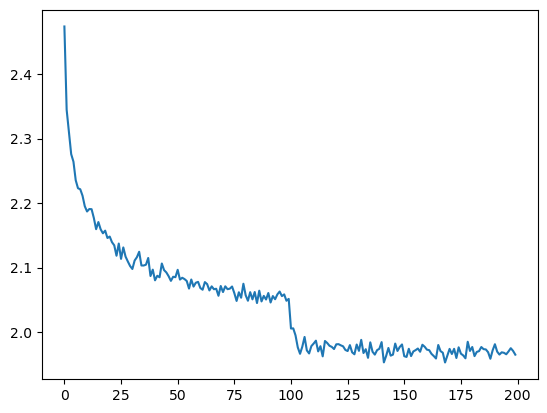

In [13]:
plt.plot(losses.reshape((-1,1000)).mean(axis=1))

In [14]:
#plt.plot(lri, lossi)
loss, _= loss_fn(params, batch_stats, Xdev, Ydev)
print(loss)

2.030033


In [15]:
# making sure you can apply the model to one example
logits, _= forward((params, batch_stats), Xdev[:1], train=False)
logits

Array([[-3.9762053 ,  2.2159538 ,  0.68939793,  0.8081271 ,  0.74260455,
         0.8729756 , -0.4588436 ,  0.21092701,  0.8146802 , -0.08305806,
         1.4781977 ,  1.4446689 ,  0.92406654,  1.4005469 ,  0.5956081 ,
        -0.41460675, -0.08544219, -1.9119741 ,  0.8527452 ,  1.1606932 ,
         0.66214454, -1.9674606 , -0.43903533, -0.922577  , -1.5928593 ,
        -0.07418329,  0.39780208]], dtype=float32)

In [16]:
# Sample from the trained model

sample_key = jax.random.PRNGKey(4206969)

for _ in range(20):
    out = []
    context = [0] * context_size

    sample_key, sample_sub_key = jax.random.split(sample_key)
    while True:
        sample_key, sample_sub_key = jax.random.split(sample_sub_key)
        logits, _ = forward((params, batch_stats), jnp.array([context]), train=False)
        ix = jax.random.categorical(sample_sub_key, logits)[0]
        context = context[1:] + [ix]
        out.append(int(ix))
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))


naziem.
cahlon.
catalie.
sama.
chutpher.
mayu.
ahlerynn.
easir.
eng.
iliyah.
ciedian.
camilin.
sadarye.
gaigan.
emeli.
madilyn.
rairan.
nahi.
vooty.
michall.
